<a href="https://colab.research.google.com/github/nitinranjansharma/EVA5B2/blob/main/s10/s10_workflow_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau

  pip install torch-lr-finder -v --global-option="amp"


In [2]:
import albumentations as A
import torchvision.transforms as transforms
import torch
from PIL import Image
from albumentations.pytorch import ToTensor
from plot_graph import plot_images, plot_graph
from utilities import *
from gradcam.visualize import VisualizeCam

In [3]:
## importing and transforming data
from read_inputs import read_transform_inputs
trainset, trainloader, testset, testloader, classes = read_transform_inputs()

Files already downloaded and verified
Files already downloaded and verified


truck horse horse  bird


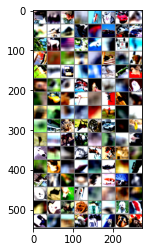

In [4]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
## defining model

from define_model import ResNet
from define_model import BasicBlock
from define_model import Bottleneck
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


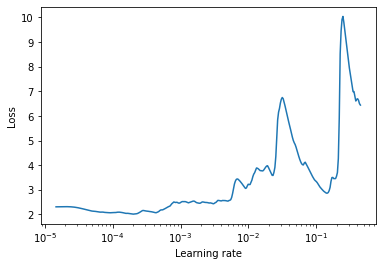

In [6]:
##defining optimiser
from define_optim import optim_define
criterion = nn.CrossEntropyLoss()
optimizer = optim_define(model)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, val_loader=testloader, start_lr=1e-5, end_lr=2,
                     num_iter=len(trainloader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [8]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))


Best Loss: 2.0114193363233173
Best Learning Rate: 0.0002002311590646604


In [9]:
from train import train
from test import test
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)
#scheduler = OneCycleLR(optimizer, max_lr=0.1, epochs=epochs,
#                      steps_per_epoch=len(trainloader))
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,
                             verbose=True, min_lr=1e-5)
epochs = 50
def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  train_losses = []
  train_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(epochs):
      print("EPOCH:", epoch+1)
      train(model, device, trainloader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs)
      
      test(model, device, testloader, criterion, classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==epochs-1)
      scheduler.step(test_losses[-1])
  return train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs

# train and test the model
train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=3e-6, l2_decay=1e-3)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=458.8873596191406 L1_loss=109422.4765625 Loss=2.7078428268432617 Batch_id=390 Accuracy=25.25: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0144, Accuracy: 3392/10000 (33.92%)

EPOCH: 2


L2_loss=458.86431884765625 L1_loss=109389.578125 Loss=2.4829845428466797 Batch_id=390 Accuracy=32.49: 100%|██████████| 391/391 [01:05<00:00,  5.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0133, Accuracy: 3856/10000 (38.56%)

EPOCH: 3


L2_loss=458.8456726074219 L1_loss=109356.6640625 Loss=2.6004979610443115 Batch_id=390 Accuracy=36.21: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0127, Accuracy: 4139/10000 (41.39%)

EPOCH: 4


L2_loss=458.82708740234375 L1_loss=109323.7421875 Loss=2.5583834648132324 Batch_id=390 Accuracy=38.63: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0120, Accuracy: 4467/10000 (44.67%)

EPOCH: 5


L2_loss=458.8070983886719 L1_loss=109291.171875 Loss=2.413455009460449 Batch_id=390 Accuracy=40.31: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0118, Accuracy: 4603/10000 (46.03%)

EPOCH: 6


L2_loss=458.7838439941406 L1_loss=109258.6015625 Loss=2.3902926445007324 Batch_id=390 Accuracy=41.76: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0114, Accuracy: 4743/10000 (47.43%)

EPOCH: 7


L2_loss=458.75958251953125 L1_loss=109226.203125 Loss=2.4003844261169434 Batch_id=390 Accuracy=42.98: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0111, Accuracy: 4886/10000 (48.86%)

EPOCH: 8


L2_loss=458.734619140625 L1_loss=109193.921875 Loss=2.4004387855529785 Batch_id=390 Accuracy=44.24: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0106, Accuracy: 5089/10000 (50.89%)

EPOCH: 9


L2_loss=458.708251953125 L1_loss=109162.0625 Loss=2.3794384002685547 Batch_id=390 Accuracy=44.75: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0106, Accuracy: 5137/10000 (51.37%)

EPOCH: 10


L2_loss=458.6823425292969 L1_loss=109129.8515625 Loss=2.2356367111206055 Batch_id=390 Accuracy=45.91: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0105, Accuracy: 5182/10000 (51.82%)

EPOCH: 11


L2_loss=458.656005859375 L1_loss=109098.015625 Loss=2.2104861736297607 Batch_id=390 Accuracy=46.75: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0103, Accuracy: 5257/10000 (52.57%)

EPOCH: 12


L2_loss=458.6297607421875 L1_loss=109066.34375 Loss=2.3600668907165527 Batch_id=390 Accuracy=47.62: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0100, Accuracy: 5395/10000 (53.95%)

EPOCH: 13


L2_loss=458.6036071777344 L1_loss=109034.7890625 Loss=2.3167002201080322 Batch_id=390 Accuracy=48.29: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0100, Accuracy: 5432/10000 (54.32%)

EPOCH: 14


L2_loss=458.57464599609375 L1_loss=109003.2109375 Loss=2.238978624343872 Batch_id=390 Accuracy=48.76: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0099, Accuracy: 5485/10000 (54.85%)

EPOCH: 15


L2_loss=458.54681396484375 L1_loss=108971.5703125 Loss=2.294506072998047 Batch_id=390 Accuracy=49.31: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0095, Accuracy: 5684/10000 (56.84%)

EPOCH: 16


L2_loss=458.5203552246094 L1_loss=108940.125 Loss=2.149566411972046 Batch_id=390 Accuracy=49.86: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0095, Accuracy: 5710/10000 (57.10%)

EPOCH: 17


L2_loss=458.4952087402344 L1_loss=108908.921875 Loss=2.1538617610931396 Batch_id=390 Accuracy=50.58: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0093, Accuracy: 5808/10000 (58.08%)

EPOCH: 18


L2_loss=458.46673583984375 L1_loss=108877.4765625 Loss=2.099092483520508 Batch_id=390 Accuracy=50.87: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0092, Accuracy: 5842/10000 (58.42%)

EPOCH: 19


L2_loss=458.4394836425781 L1_loss=108846.53125 Loss=2.2122437953948975 Batch_id=390 Accuracy=51.57: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0092, Accuracy: 5841/10000 (58.41%)

EPOCH: 20


L2_loss=458.4111633300781 L1_loss=108815.4609375 Loss=2.426973342895508 Batch_id=390 Accuracy=51.95: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0092, Accuracy: 5825/10000 (58.25%)

EPOCH: 21


L2_loss=458.3833312988281 L1_loss=108784.6640625 Loss=2.111128568649292 Batch_id=390 Accuracy=52.34: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0090, Accuracy: 5935/10000 (59.35%)

EPOCH: 22


L2_loss=458.357177734375 L1_loss=108753.859375 Loss=2.0978479385375977 Batch_id=390 Accuracy=52.82: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0088, Accuracy: 6029/10000 (60.29%)

EPOCH: 23


L2_loss=458.32940673828125 L1_loss=108723.1484375 Loss=1.9997406005859375 Batch_id=390 Accuracy=53.42: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0086, Accuracy: 6128/10000 (61.28%)

EPOCH: 24


L2_loss=458.3013916015625 L1_loss=108692.328125 Loss=1.9125661849975586 Batch_id=390 Accuracy=53.67: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0087, Accuracy: 6044/10000 (60.44%)

EPOCH: 25


L2_loss=458.27276611328125 L1_loss=108661.6171875 Loss=2.154247760772705 Batch_id=390 Accuracy=54.03: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0090, Accuracy: 5971/10000 (59.71%)

EPOCH: 26


L2_loss=458.2457275390625 L1_loss=108631.125 Loss=1.990814447402954 Batch_id=390 Accuracy=54.60: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0083, Accuracy: 6264/10000 (62.64%)

EPOCH: 27


L2_loss=458.2162780761719 L1_loss=108600.7109375 Loss=2.0407681465148926 Batch_id=390 Accuracy=54.56: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0085, Accuracy: 6124/10000 (61.24%)

EPOCH: 28


L2_loss=458.1897277832031 L1_loss=108570.3515625 Loss=2.15226149559021 Batch_id=390 Accuracy=55.23: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 6307/10000 (63.07%)

EPOCH: 29


L2_loss=458.1630554199219 L1_loss=108540.0625 Loss=2.191749095916748 Batch_id=390 Accuracy=55.73: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0084, Accuracy: 6203/10000 (62.03%)

EPOCH: 30


L2_loss=458.13690185546875 L1_loss=108509.59375 Loss=2.0706048011779785 Batch_id=390 Accuracy=56.05: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 6476/10000 (64.76%)

EPOCH: 31


L2_loss=458.1100158691406 L1_loss=108479.5625 Loss=1.8906633853912354 Batch_id=390 Accuracy=56.61: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0082, Accuracy: 6326/10000 (63.26%)

EPOCH: 32


L2_loss=458.0798645019531 L1_loss=108449.3828125 Loss=1.8970201015472412 Batch_id=390 Accuracy=56.75: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 6418/10000 (64.18%)

EPOCH: 33


L2_loss=458.0539245605469 L1_loss=108419.34375 Loss=1.954043984413147 Batch_id=390 Accuracy=56.96: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 6429/10000 (64.29%)

EPOCH: 34


L2_loss=458.0270080566406 L1_loss=108389.421875 Loss=1.868958830833435 Batch_id=390 Accuracy=57.27: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 6461/10000 (64.61%)

EPOCH: 35


L2_loss=457.9997253417969 L1_loss=108359.3203125 Loss=1.9523851871490479 Batch_id=390 Accuracy=57.91: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0080, Accuracy: 6458/10000 (64.58%)

EPOCH: 36


L2_loss=457.97198486328125 L1_loss=108329.421875 Loss=1.8741521835327148 Batch_id=390 Accuracy=58.03: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 6516/10000 (65.16%)

EPOCH: 37


L2_loss=457.94244384765625 L1_loss=108299.546875 Loss=1.8902976512908936 Batch_id=390 Accuracy=58.35: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0078, Accuracy: 6532/10000 (65.32%)

EPOCH: 38


L2_loss=457.9151306152344 L1_loss=108269.9765625 Loss=1.8942402601242065 Batch_id=390 Accuracy=58.36: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 6565/10000 (65.65%)

EPOCH: 39


L2_loss=457.8869323730469 L1_loss=108240.4609375 Loss=1.9500305652618408 Batch_id=390 Accuracy=58.61: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 6662/10000 (66.62%)

EPOCH: 40


L2_loss=457.85882568359375 L1_loss=108211.03125 Loss=2.164842128753662 Batch_id=390 Accuracy=58.92: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0076, Accuracy: 6654/10000 (66.54%)

EPOCH: 41


L2_loss=457.8313293457031 L1_loss=108181.375 Loss=1.8328900337219238 Batch_id=390 Accuracy=59.41: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 6630/10000 (66.30%)

EPOCH: 42


L2_loss=457.8033752441406 L1_loss=108151.6015625 Loss=1.9215850830078125 Batch_id=390 Accuracy=59.74: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0077, Accuracy: 6622/10000 (66.22%)

EPOCH: 43


L2_loss=457.7746276855469 L1_loss=108121.9453125 Loss=1.8565198183059692 Batch_id=390 Accuracy=59.94: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 6645/10000 (66.45%)

Epoch    43: reducing learning rate of group 0 to 2.0023e-05.
EPOCH: 44


L2_loss=457.76995849609375 L1_loss=108118.3359375 Loss=1.9324105978012085 Batch_id=390 Accuracy=61.51: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0070, Accuracy: 6861/10000 (68.61%)

EPOCH: 45


L2_loss=457.7659912109375 L1_loss=108114.828125 Loss=1.919491171836853 Batch_id=390 Accuracy=61.56: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0069, Accuracy: 6898/10000 (68.98%)

EPOCH: 46


L2_loss=457.76165771484375 L1_loss=108111.296875 Loss=1.9521851539611816 Batch_id=390 Accuracy=61.50: 100%|██████████| 391/391 [01:05<00:00,  5.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0070, Accuracy: 6881/10000 (68.81%)

EPOCH: 47


L2_loss=457.75787353515625 L1_loss=108107.765625 Loss=1.9932749271392822 Batch_id=390 Accuracy=61.71: 100%|██████████| 391/391 [01:05<00:00,  5.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0069, Accuracy: 6897/10000 (68.97%)

EPOCH: 48


L2_loss=457.75372314453125 L1_loss=108104.1953125 Loss=1.9589226245880127 Batch_id=390 Accuracy=62.35: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0069, Accuracy: 6893/10000 (68.93%)

EPOCH: 49


L2_loss=457.75006103515625 L1_loss=108100.6796875 Loss=2.0508060455322266 Batch_id=390 Accuracy=62.20: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0069, Accuracy: 6907/10000 (69.07%)

EPOCH: 50


L2_loss=457.746337890625 L1_loss=108097.1484375 Loss=1.8356317281723022 Batch_id=390 Accuracy=62.46: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
/content/test.py:24: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  misclassified_inds = (is_correct == 0).nonzero()[:, 0]


Test set: Average loss: 0.0069, Accuracy: 6879/10000 (68.79%)



GroundTruth:    cat  ship  ship plane


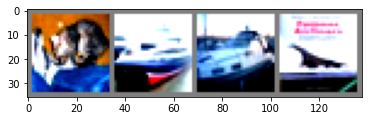

In [10]:
## checking test images

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

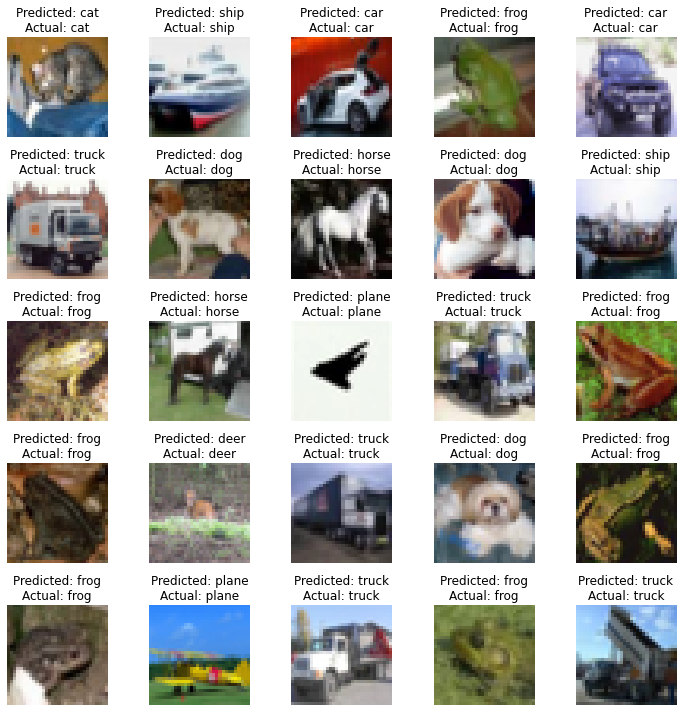

In [ ]:
## correct images
plot_images(correct_imgs, classes, "correct_imgs.png")

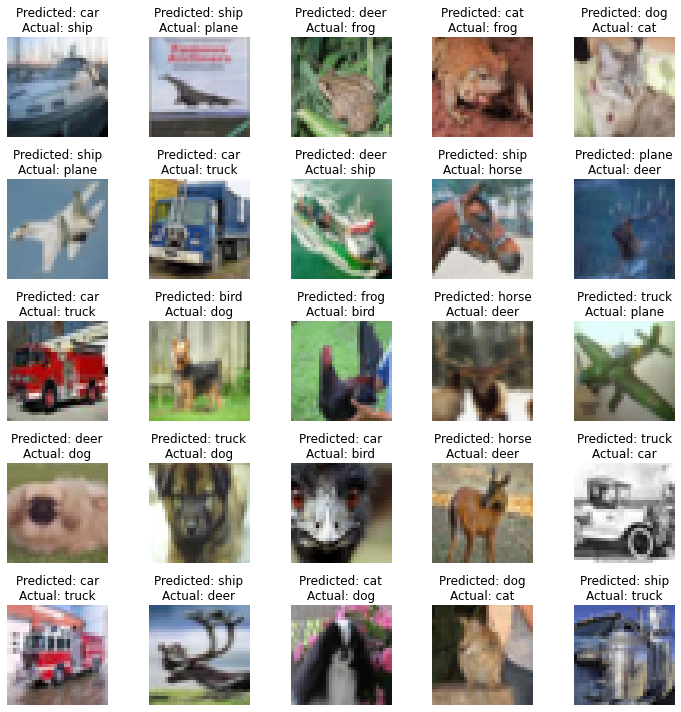

In [ ]:
plot_images(misclassified_imgs, classes, "misclassified_imgs.png")

In [ ]:
from accuracy_check import check_accuracy     
check_accuracy(testloader,device,model)

Accuracy of the network on the 10000 test images: 50 %


50.46

In [ ]:
torch.save(model,"model_2.sav")

In [ ]:
from gradcam.visualize import VisualizeCam

In [ ]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,classes, target_layers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

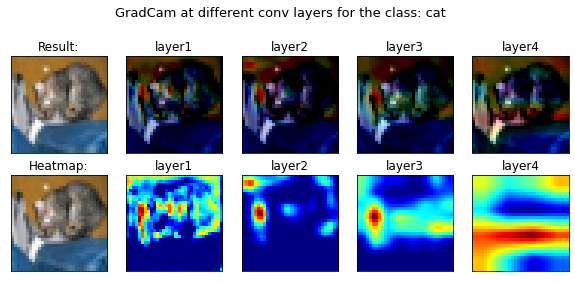

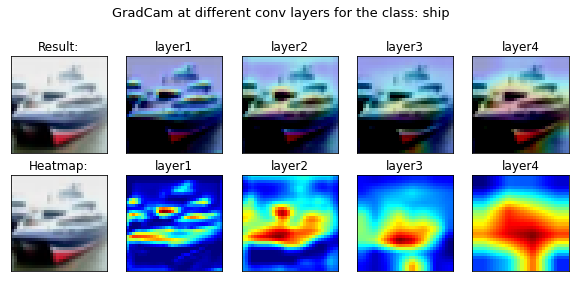

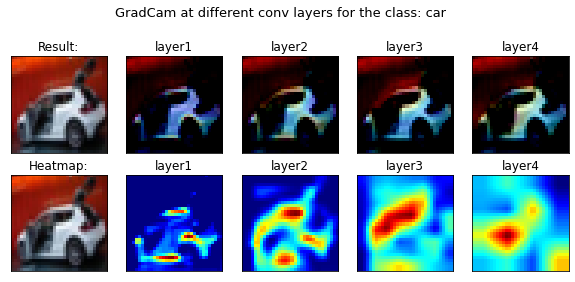

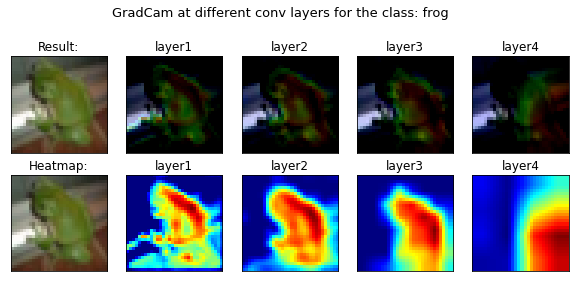

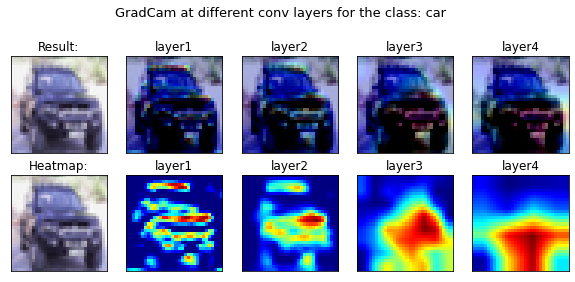

In [ ]:
##Correct Images
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(torch.as_tensor(correct_imgs[i]["img"]))
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="correct")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

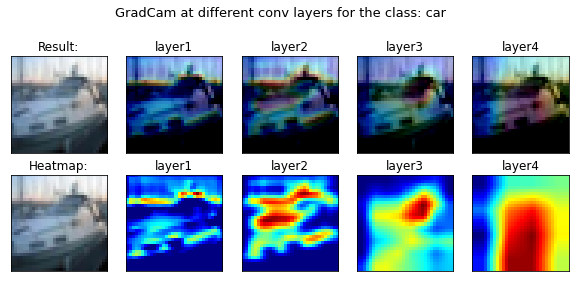

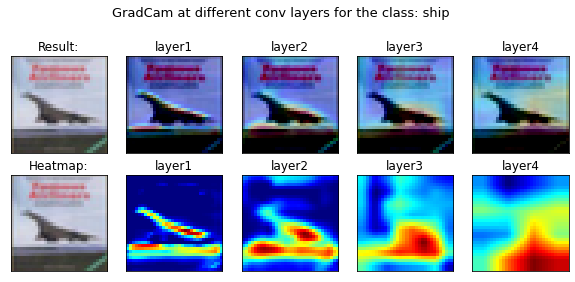

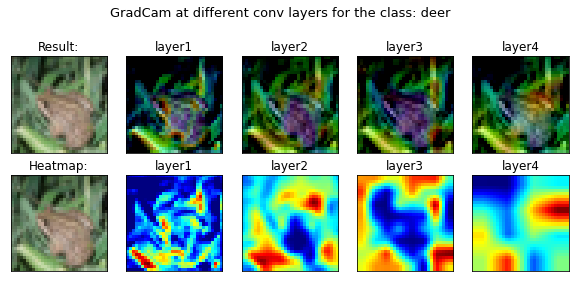

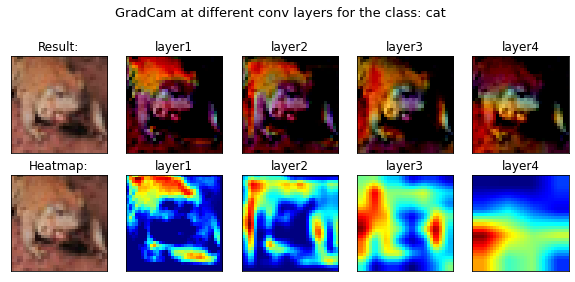

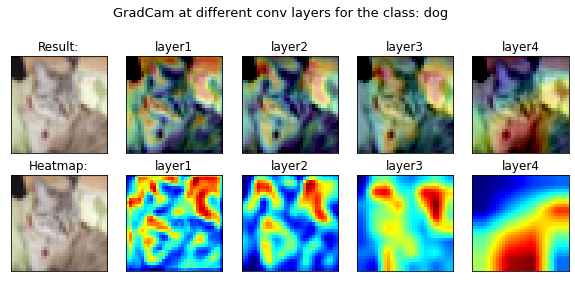

In [ ]:
##Misclassfied
incorrect_pred_imgs = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
viz_cam(torch.stack(incorrect_pred_imgs), target_layers, metric="incorrect")